# chronos-t5-large

In [ ]:
import matplotlib.pyplot as plt  # ТОП прогноз самый большой(на проце очень медленный)+ праздничные дни
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

# Загружаем модель напрямую из Hugging Face
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)
print(f"PyTorch использует устройство: {torch.cuda.current_device()} (GPU)" if torch.cuda.is_available() else "PyTorch использует устройство: CPU")

# Загружаем данные
data = pd.read_csv('C:/Users/bondarenkovv/Desktop/Python/Chronos/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].astype(str).str.replace(',', '.').astype(float)
data = data.drop_duplicates(subset=['store', 'ds']).dropna()
data = data.sort_values(by=['store', 'ds']).reset_index(drop=True)

# Заполняем пропущенные даты
date_range = pd.date_range(start=data['ds'].min(), end=data['ds'].max(), freq='D')
all_stores = data['store'].unique()
full_index = pd.MultiIndex.from_product([all_stores, date_range], names=['store', 'ds'])
data = data.set_index(['store', 'ds']).reindex(full_index).fillna(0).reset_index()

# Параметры прогнозирования
prediction_length = 40  # Прогноз на 40 дней
last_n_days = 14  # Период для проверки активности магазина (последние 14 дней)

# Определяем активные магазины (те, у которых есть продажи за последние 14 дней)
last_date = data['ds'].max()
active_stores = []
for store in all_stores:
    store_data = data[(data['store'] == store) & (data['ds'] > last_date - pd.Timedelta(days=last_n_days))]
    if store_data['y'].sum() > 0:  # Если сумма продаж за последние 14 дней больше 0
        active_stores.append(store)

print(f"Активные магазины (с продажами за последние {last_n_days} дней): {len(active_stores)} из {len(all_stores)}")

# Список для хранения прогнозов
forecasts = []

# Прогноз только для активных магазинов с выводом подсказок
for store in active_stores:
    print(f"Рассчитывается прогноз для магазина: {store}")
    # Выбираем данные для текущего магазина
    store_data = data[data['store'] == store]['y'].values
    context = torch.tensor(store_data, dtype=torch.float32)  # Контекст — исторические данные
    
    # Генерируем прогноз
    forecast = pipeline.predict(context, prediction_length)  # shape: [1, num_samples, prediction_length]
    forecasts.append(forecast[0].numpy())  # Сохраняем прогноз как numpy массив
    print(f"Прогноз для магазина {store} успешно рассчитан")

# Преобразуем прогнозы в DataFrame
forecast_df = pd.DataFrame({
    'store': active_stores,
    'forecast': [np.median(f, axis=0) for f in forecasts]  # Берем медиану по сэмплам
})

# Разворачиваем прогноз по дням
forecast_days = pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=prediction_length, freq='D')
forecast_expanded = forecast_df.explode('forecast').reset_index(drop=True)
forecast_expanded['ds'] = forecast_days.tolist() * len(active_stores)

# Добавляем предпраздничные дни вручную
pre_holiday_dates = pd.to_datetime([
    '2025-02-22', '2025-03-07', '2025-04-19', '2025-05-08', '2025-06-11', '2025-04-20', '2025-05-02', 
    '2025-05-03', '2025-12-28', '2025-12-29', '2025-12-30', '2025-12-31'
])
forecast_expanded['is_pre_holiday'] = forecast_expanded['ds'].isin(pre_holiday_dates).astype(int)

# Корректируем прогноз только для предпраздничных дней
forecast_expanded['forecast'] = forecast_expanded['forecast'] * (1 + 0.165 * forecast_expanded['is_pre_holiday'])

# Сохраняем результат
forecast_expanded.to_excel('Chronos_T5_Forecast_with_pre_holidays_large.xlsx', index=False)
print("Прогноз успешно сохранен!")

# chronos-bolt-base

In [2]:
import pandas as pd                               # ТОП прогноз(очень быстрый) надо тестить
import torch
from chronos import BaseChronosPipeline
import numpy as np

# Инициализируем пайплайн
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

print(f"PyTorch использует устройство: {torch.cuda.current_device()} (GPU)" if torch.cuda.is_available() else "PyTorch использует устройство: CPU")

# Загружаем данные
data = pd.read_csv('C:/Users/bondarenkovv/Desktop/Python/Chronos/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].astype(str).str.replace(',', '.').astype(float)
data = data.drop_duplicates(subset=['store', 'ds']).dropna()
data = data.sort_values(by=['store', 'ds']).reset_index(drop=True)

# Заполняем пропущенные даты
date_range = pd.date_range(start=data['ds'].min(), end=data['ds'].max(), freq='D')
all_stores = data['store'].unique()
full_index = pd.MultiIndex.from_product([all_stores, date_range], names=['store', 'ds'])
data = data.set_index(['store', 'ds']).reindex(full_index).fillna(0).reset_index()

# Параметры прогнозирования
prediction_length = 40  # Прогноз на 40 дней
last_n_days = 14  # Период для проверки активности магазина (последние 14 дней)

# Определяем активные магазины (те, у которых есть продажи за последние 14 дней)
last_date = data['ds'].max()
active_stores = []
for store in all_stores:
    store_data = data[(data['store'] == store) & (data['ds'] > last_date - pd.Timedelta(days=last_n_days))]
    if store_data['y'].sum() > 0:  # Если сумма продаж за последние 14 дней больше 0
        active_stores.append(store)

print(f"Активные магазины (с продажами за последние {last_n_days} дней): {len(active_stores)} из {len(all_stores)}")

# Список для хранения прогнозов
forecasts = []

# Прогноз только для активных магазинов с подсказками
for store in active_stores:
    print(f"Рассчитывается прогноз для магазина: {store}")
    store_data = data[data['store'] == store]['y'].values
    context = torch.tensor(store_data, dtype=torch.float32)
    forecast = pipeline.predict(context, prediction_length)
    forecasts.append(forecast[0].numpy())
    print(f"Прогноз для магазина {store} успешно рассчитан")

# Преобразуем прогнозы в DataFrame
forecast_df = pd.DataFrame({
    'store': active_stores,
    'forecast': [np.median(f, axis=0) for f in forecasts]
})

# Разворачиваем прогноз по дням
forecast_days = pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=prediction_length, freq='D')
forecast_expanded = forecast_df.explode('forecast').reset_index(drop=True)
forecast_expanded['ds'] = forecast_days.tolist() * len(active_stores)

# Убираем отрицательные прогнозы (устанавливаем минимум 0)
forecast_expanded['forecast'] = forecast_expanded['forecast'].clip(lower=0)

# Добавляем предпраздничные дни
pre_holiday_dates = pd.to_datetime([
    '2025-02-22', '2025-03-07', '2025-04-19', '2025-05-08', '2025-06-11', '2025-04-20', '2025-05-02', 
    '2025-05-03', '2025-12-28', '2025-12-29', '2025-12-30', '2025-12-31'
])
forecast_expanded['is_pre_holiday'] = forecast_expanded['ds'].isin(pre_holiday_dates).astype(int)

# Корректируем прогноз для предпраздничных дней
forecast_expanded['forecast'] = forecast_expanded['forecast'] * (1 + 0.165 * forecast_expanded['is_pre_holiday'])

# Сохраняем результат
forecast_expanded.to_excel('Chronos_T5_Forecast_with_pre_holidays.xlsx', index=False)
print("Прогноз успешно сохранен!")

PyTorch использует устройство: 0 (GPU)
Активные магазины (с продажами за последние 14 дней): 174 из 185
Рассчитывается прогноз для магазина: 1


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Прогноз для магазина 1 успешно рассчитан
Рассчитывается прогноз для магазина: 65
Прогноз для магазина 65 успешно рассчитан
Рассчитывается прогноз для магазина: 66
Прогноз для магазина 66 успешно рассчитан
Рассчитывается прогноз для магазина: 67
Прогноз для магазина 67 успешно рассчитан
Рассчитывается прогноз для магазина: 68
Прогноз для магазина 68 успешно рассчитан
Рассчитывается прогноз для магазина: 69
Прогноз для магазина 69 успешно рассчитан
Рассчитывается прогноз для магазина: 70
Прогноз для магазина 70 успешно рассчитан
Рассчитывается прогноз для магазина: 71
Прогноз для магазина 71 успешно рассчитан
Рассчитывается прогноз для магазина: 72
Прогноз для магазина 72 успешно рассчитан
Рассчитывается прогноз для магазина: 73
Прогноз для магазина 73 успешно рассчитан
Рассчитывается прогноз для магазина: 74
Прогноз для магазина 74 успешно рассчитан
Рассчитывается прогноз для магазина: 75
Прогноз для магазина 75 успешно рассчитан
Рассчитывается прогноз для магазина: 76
Прогноз для магаз

# График

C:\Users\bondarenkovv\AppData\Local\Temp\ipykernel_15720\1189348555.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Стиль Seaborn для красивого отображения


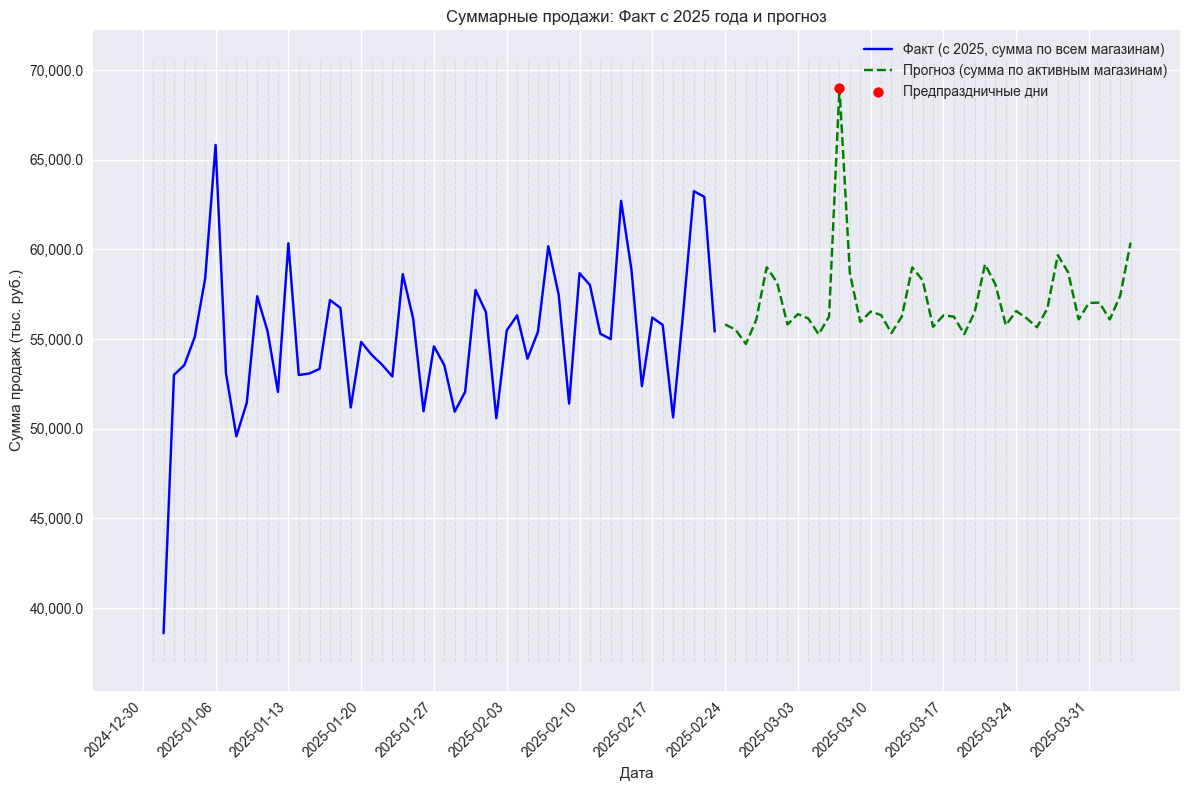

График с суммарными фактическими данными с 2025 года, прогнозом и ежедневной пунктирной сеткой построен и сохранен!


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Настройки для графиков
plt.style.use('seaborn')  # Стиль Seaborn для красивого отображения
plt.rcParams['figure.figsize'] = (12, 8)  # Увеличим ширину для лучшей видимости

# Фильтруем фактические данные с начала 2025 года и считаем сумму по всем магазинам
start_date = pd.to_datetime('2025-01-01')
fact_2025 = data[data['ds'] >= start_date].copy()
fact_total = fact_2025.groupby('ds')['y'].sum().reset_index()

# Считаем суммарный прогноз по всем активным магазинам
forecast_total = forecast_expanded.groupby('ds')['forecast'].sum().reset_index()
forecast_total['is_pre_holiday'] = forecast_total['ds'].isin(pre_holiday_dates).astype(int)

# Определяем пользовательские метки с шагом 7 дней, начиная с 30 декабря 2024
start_xticks = pd.to_datetime('2024-12-30')
end_date = forecast_total['ds'].max()  # Последняя дата прогноза
xticks = pd.date_range(start=start_xticks, end=end_date, freq='7D')

# Определяем ежедневные линии для дополнительной сетки
daily_lines = pd.date_range(start=start_xticks, end=end_date, freq='D')

# Построение графика
plt.figure()
# Факт (в тысячах рублей)
plt.plot(fact_total['ds'], fact_total['y'] / 1000, label='Факт (с 2025, сумма по всем магазинам)', color='blue')
# Прогноз (в тысячах рублей)
plt.plot(forecast_total['ds'], forecast_total['forecast'] / 1000, label='Прогноз (сумма по активным магазинам)', color='green', linestyle='--')
# Отмечаем предпраздничные дни на прогнозе (в тысячах рублей)
pre_holiday_forecast = forecast_total[forecast_total['is_pre_holiday'] == 1]
plt.scatter(pre_holiday_forecast['ds'], pre_holiday_forecast['forecast'] / 1000, 
            color='red', label='Предпраздничные дни', zorder=5, s=50)

# Добавляем светлые серые пунктирные линии для каждого дня
plt.vlines(daily_lines, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], 
           colors='lightgrey', linestyles='dashed', linewidth=0.8, alpha=0.8, zorder=0)

plt.title('Суммарные продажи: Факт с 2025 года и прогноз')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж (тыс. руб.)')  # Подпись оси Y в тысячах рублей
plt.legend()
plt.grid(True)

# Устанавливаем метки с шагом 7 дней для оси X
plt.xticks(xticks, rotation=45, ha='right')  # Метки каждые 7 дней с 30 декабря 2024
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Формат даты

# Форматируем ось Y для отображения с одним знаком после запятой
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:,.1f}'))

plt.tight_layout()
plt.savefig('Total_fact_2025_forecast_7days_with_daily_grid.png')  # Сохранение графика
plt.show()

print("График с суммарными фактическими данными с 2025 года, прогнозом и ежедневной пунктирной сеткой построен и сохранен!")